In [1]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Base path where all method folders are
METHOD = "mpc"
base_path = f'./ABR_Separated/{METHOD}/'

# Quality labels to predict
quality_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']

# Collect all merged CSVs
all_dfs = []

print("Loading CSV files...")

# Loop through each ABR method folder
path_pattern = os.path.join(base_path, '*.csv')  # Match all CSVs under each method folder
for file_path in glob(path_pattern):
    try:
        df = pd.read_csv(file_path, dtype=str)
        all_dfs.append(df)
        print(df.head())
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

Loading CSV files...
         time (ns GMT)                                    session_id index_x  \
0  1548500400373000000  fciPebAXJYTgwuEwS8Pd9wRVEfd0w3ql1/Nwzhjg2Vs=       0   
1  1548500401329000000  GzdpvodlEXYvK2J5jeT0ZAk1wVaDLd+wIr75A+RCCaY=       0   
2  1548500401728000000  QlFt5Mb2B+CQBvIjVPYTC0H94KAKcSSiDDYwd0Z2sHc=       0   
3  1548500402374000000  fciPebAXJYTgwuEwS8Pd9wRVEfd0w3ql1/Nwzhjg2Vs=       0   
4  1548500403329000000  GzdpvodlEXYvK2J5jeT0ZAk1wVaDLd+wIr75A+RCCaY=       0   

  expt_id_x channel_x     video_ts        format     size ssim_index cwnd  \
0       234       fox  38277619380   1280x720-20   692788   0.983757   61   
1       234       pbs  38254916700  1920x1080-22   221530   0.986023   47   
2       234       nbc  38278520280  1920x1080-22  1192372   0.984555   27   
3       234       fox  38277799560   1280x720-20   807355   0.982235   65   
4       234       pbs  38255096880  1920x1080-22   448644   0.987116   48   

   ...    rtt delivery_rate        

In [2]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

Combining CSVs into one DataFrame...
Total rows loaded: 124488


In [ ]:
# Drop columns
# All columns
# Index(['time (ns GMT)', 'session_id', 'index_x', 'expt_id_x', 'channel_x',
    #    'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
    #    'min_rtt', 'rtt', 'delivery_rate', 'source_dataset_x', 'index_y',
    #    'expt_id_y', 'channel_y', 'event', 'buffer', 'cum_rebuf',
    #    'source_dataset_y'],
# Why i dropped: https://puffer.stanford.edu/data-description/
non_mpc_columns = [
    'time (ns GMT)', 'session_id', 'index_x', 'expt_id_x', 'channel_x',
    'video_ts', 'format', 'ssim_index', 'source_dataset_x', 'index_y',
    'expt_id_y', 'channel_y'
]

# df_mpc = df.drop(columns=non_mpc_columns)
print(data.columns)

Index(['time (ns GMT)', 'session_id', 'index_x', 'expt_id_x', 'channel_x',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'source_dataset_x', 'index_y',
       'expt_id_y', 'channel_y', 'event', 'buffer', 'cum_rebuf',
       'source_dataset_y'],
      dtype='object')


In [7]:
# Drop rows with missing target values
# Step 1: Create a mask for valid rows (where at least one quality > 0)
valid_rows = data[quality_labels].astype(float).sum(axis=1) > 0

# Step 2: Initialize PlaybackQuality as None (for all rows)
data['PlaybackQuality'] = None

# Step 3: Only assign idxmax to valid rows
data.loc[valid_rows, 'PlaybackQuality'] = (
    data.loc[valid_rows, quality_labels].astype(float).idxmax(axis=1)
)

# Step 4: Map to integer class labels
quality_to_index = {q: i for i, q in enumerate(quality_labels)}
data['PlaybackQuality'] = data['PlaybackQuality'].map(quality_to_index)

# Step 5: Drop rows with missing PlaybackQuality
data = data.dropna(subset=['PlaybackQuality'])

In [8]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')

/var/folders/d9/210kwmkj07x7qlhkkmmnw4z80000gn/T/ipykernel_11600/2811802303.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col], errors='ignore')
Converting columns to numeric: 100%|██████████| 208/208 [01:46<00:00,  1.95it/s]


In [9]:
# Drop original quality columns
data = data.drop(columns=quality_labels)

In [10]:
# Drop any remaining non-numeric columns
# data = data.select_dtypes(include=['number', 'bool'])
data = data.select_dtypes(include=['number'])
print(data)

         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
61                6.1           24               45       2554          61722   
62                6.2           39               77       3185         107184   
63                6.3           35               68       3639          93308   
64                6.4           10               17       1872          17093   
65                6.5           24               39       2510          48130   
...               ...          ...              ...        ...            ...   
3377066        1799.6            0                0          0              0   
3377067        1799.7            0                0          0              0   
3377068        1799.8            0                0          0              0   
3377069        1799.9            0                0          0              0   
3377070        1800.0            0                0          0              0   

         PacketsSent0  Pack

In [11]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [12]:
print(y)
print(X)

61         3
62         3
63         3
64         3
65         3
          ..
3377066    0
3377067    0
3377068    0
3377069    0
3377070    0
Name: PlaybackQuality, Length: 3240093, dtype: int64
         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
61                6.1           24               45       2554          61722   
62                6.2           39               77       3185         107184   
63                6.3           35               68       3639          93308   
64                6.4           10               17       1872          17093   
65                6.5           24               39       2510          48130   
...               ...          ...              ...        ...            ...   
3377066        1799.6            0                0          0              0   
3377067        1799.7            0                0          0              0   
3377068        1799.8            0                0          0             

In [13]:
X = X.drop(columns=['StartTime', 'EpochTime'])

# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("Evaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...
Evaluating model...


Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.61      0.59     83617
         1.0       0.57      0.58      0.57     82856
         2.0       0.61      0.59      0.60     88984
         3.0       0.71      0.67      0.69    110808
         4.0       0.87      0.87      0.87    170605
         5.0       0.93      0.93      0.93    111149

    accuracy                           0.74    648019
   macro avg       0.71      0.71      0.71    648019
weighted avg       0.74      0.74      0.74    648019



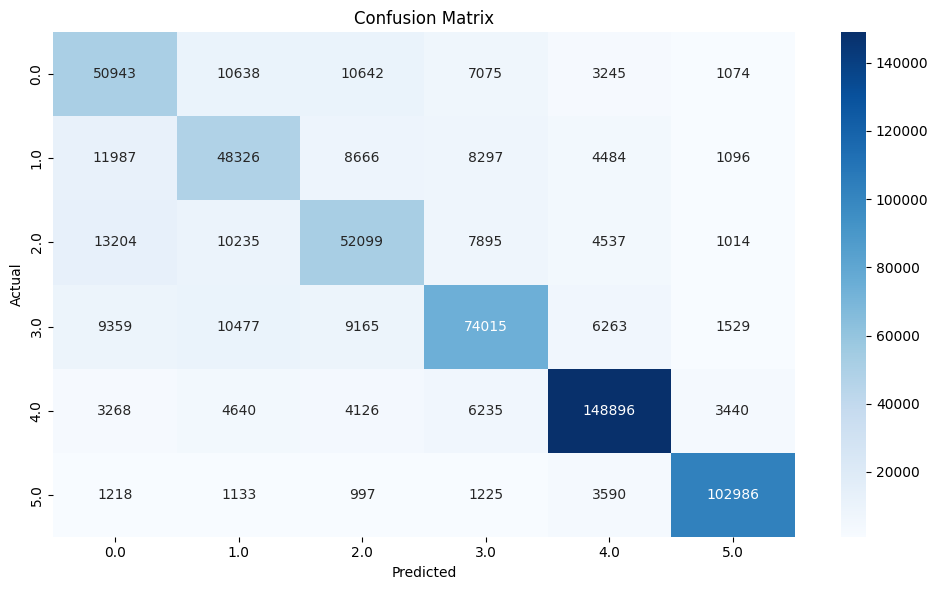

In [14]:
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("Classification Report:")
print(classification_report(y_test_str, y_pred_str, target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [15]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

BufferHealth: 0.3234
RelativeTime: 0.1921
PlaybackProgress: 0.1671
BufferProgress: 0.1163
Length: 0.1116
BytesReceived: 0.0119
BytesSent: 0.0111
BytesSent0: 0.0102
PacketsSent0: 0.0090
PacketsReceived0: 0.0085
PacketsReceived: 0.0079
PacketsSent: 0.0075
BytesReceived0: 0.0062
BytesReceived25: 0.0017
PacketsReceived25: 0.0012
BytesReceived1: 0.0007
BytesSent25: 0.0007
BytesSent1: 0.0006
BytesReceived2: 0.0005
PacketsReceived1: 0.0005


In [16]:
concept_dict = {
    'TrafficSent': [f'BytesSent{i}' for i in range(26)] + [f'PacketsSent{i}' for i in range(26)],
    'TrafficReceived': [f'BytesReceived{i}' for i in range(26)] + [f'PacketsReceived{i}' for i in range(26)],
    'Buffering': ['BufferHealth', 'BufferProgress'],
    'Playback': ['PlaybackProgress', 'Length', 'Paused', 'Playing'],
    'Timing': ['RelativeTime'],  # Could include more if other time columns existed
}

for concept, features in concept_dict.items():
    concept_dict[concept] = [f for f in features if f in X.columns]

In [17]:
def make_concept_features(X, concept_dict, agg='mean'):
    X_concepts = pd.DataFrame(index=X.index)
    for concept, cols in concept_dict.items():
        valid_cols = [col for col in cols if col in X.columns]
        if not valid_cols:
            continue
        if agg == 'mean':
            X_concepts[concept] = X[valid_cols].mean(axis=1)
        elif agg == 'max':
            X_concepts[concept] = X[valid_cols].max(axis=1)
        elif agg == 'sum':
            X_concepts[concept] = X[valid_cols].sum(axis=1)
    return X_concepts

X_test_concepts = make_concept_features(X_test, concept_dict)

In [18]:
print(X_test_concepts)

         TrafficSent  TrafficReceived   Buffering    Playback  Timing
1269865     6.250000       187.519231   31.239014  240.321336   175.5
733754     36.461538      1125.115385   12.715824  238.548379    53.4
330118     11.865385         0.000000  112.779674  366.885632   557.8
779082      0.000000         0.000000  101.276756  263.048437   379.2
2700520     0.000000         0.000000   60.627516  190.234187   203.0
...              ...              ...         ...         ...     ...
1737878     7.826923       241.096154   37.735553  158.784189    98.8
2488702    11.826923         1.442308   35.578154  179.979370    56.2
2381088     0.000000         0.000000   33.895507  172.107218   112.8
590933      0.000000         0.000000   69.173756  184.166243   195.3
2531103     0.000000         0.000000   57.308967  180.074807    89.3

[648019 rows x 5 columns]


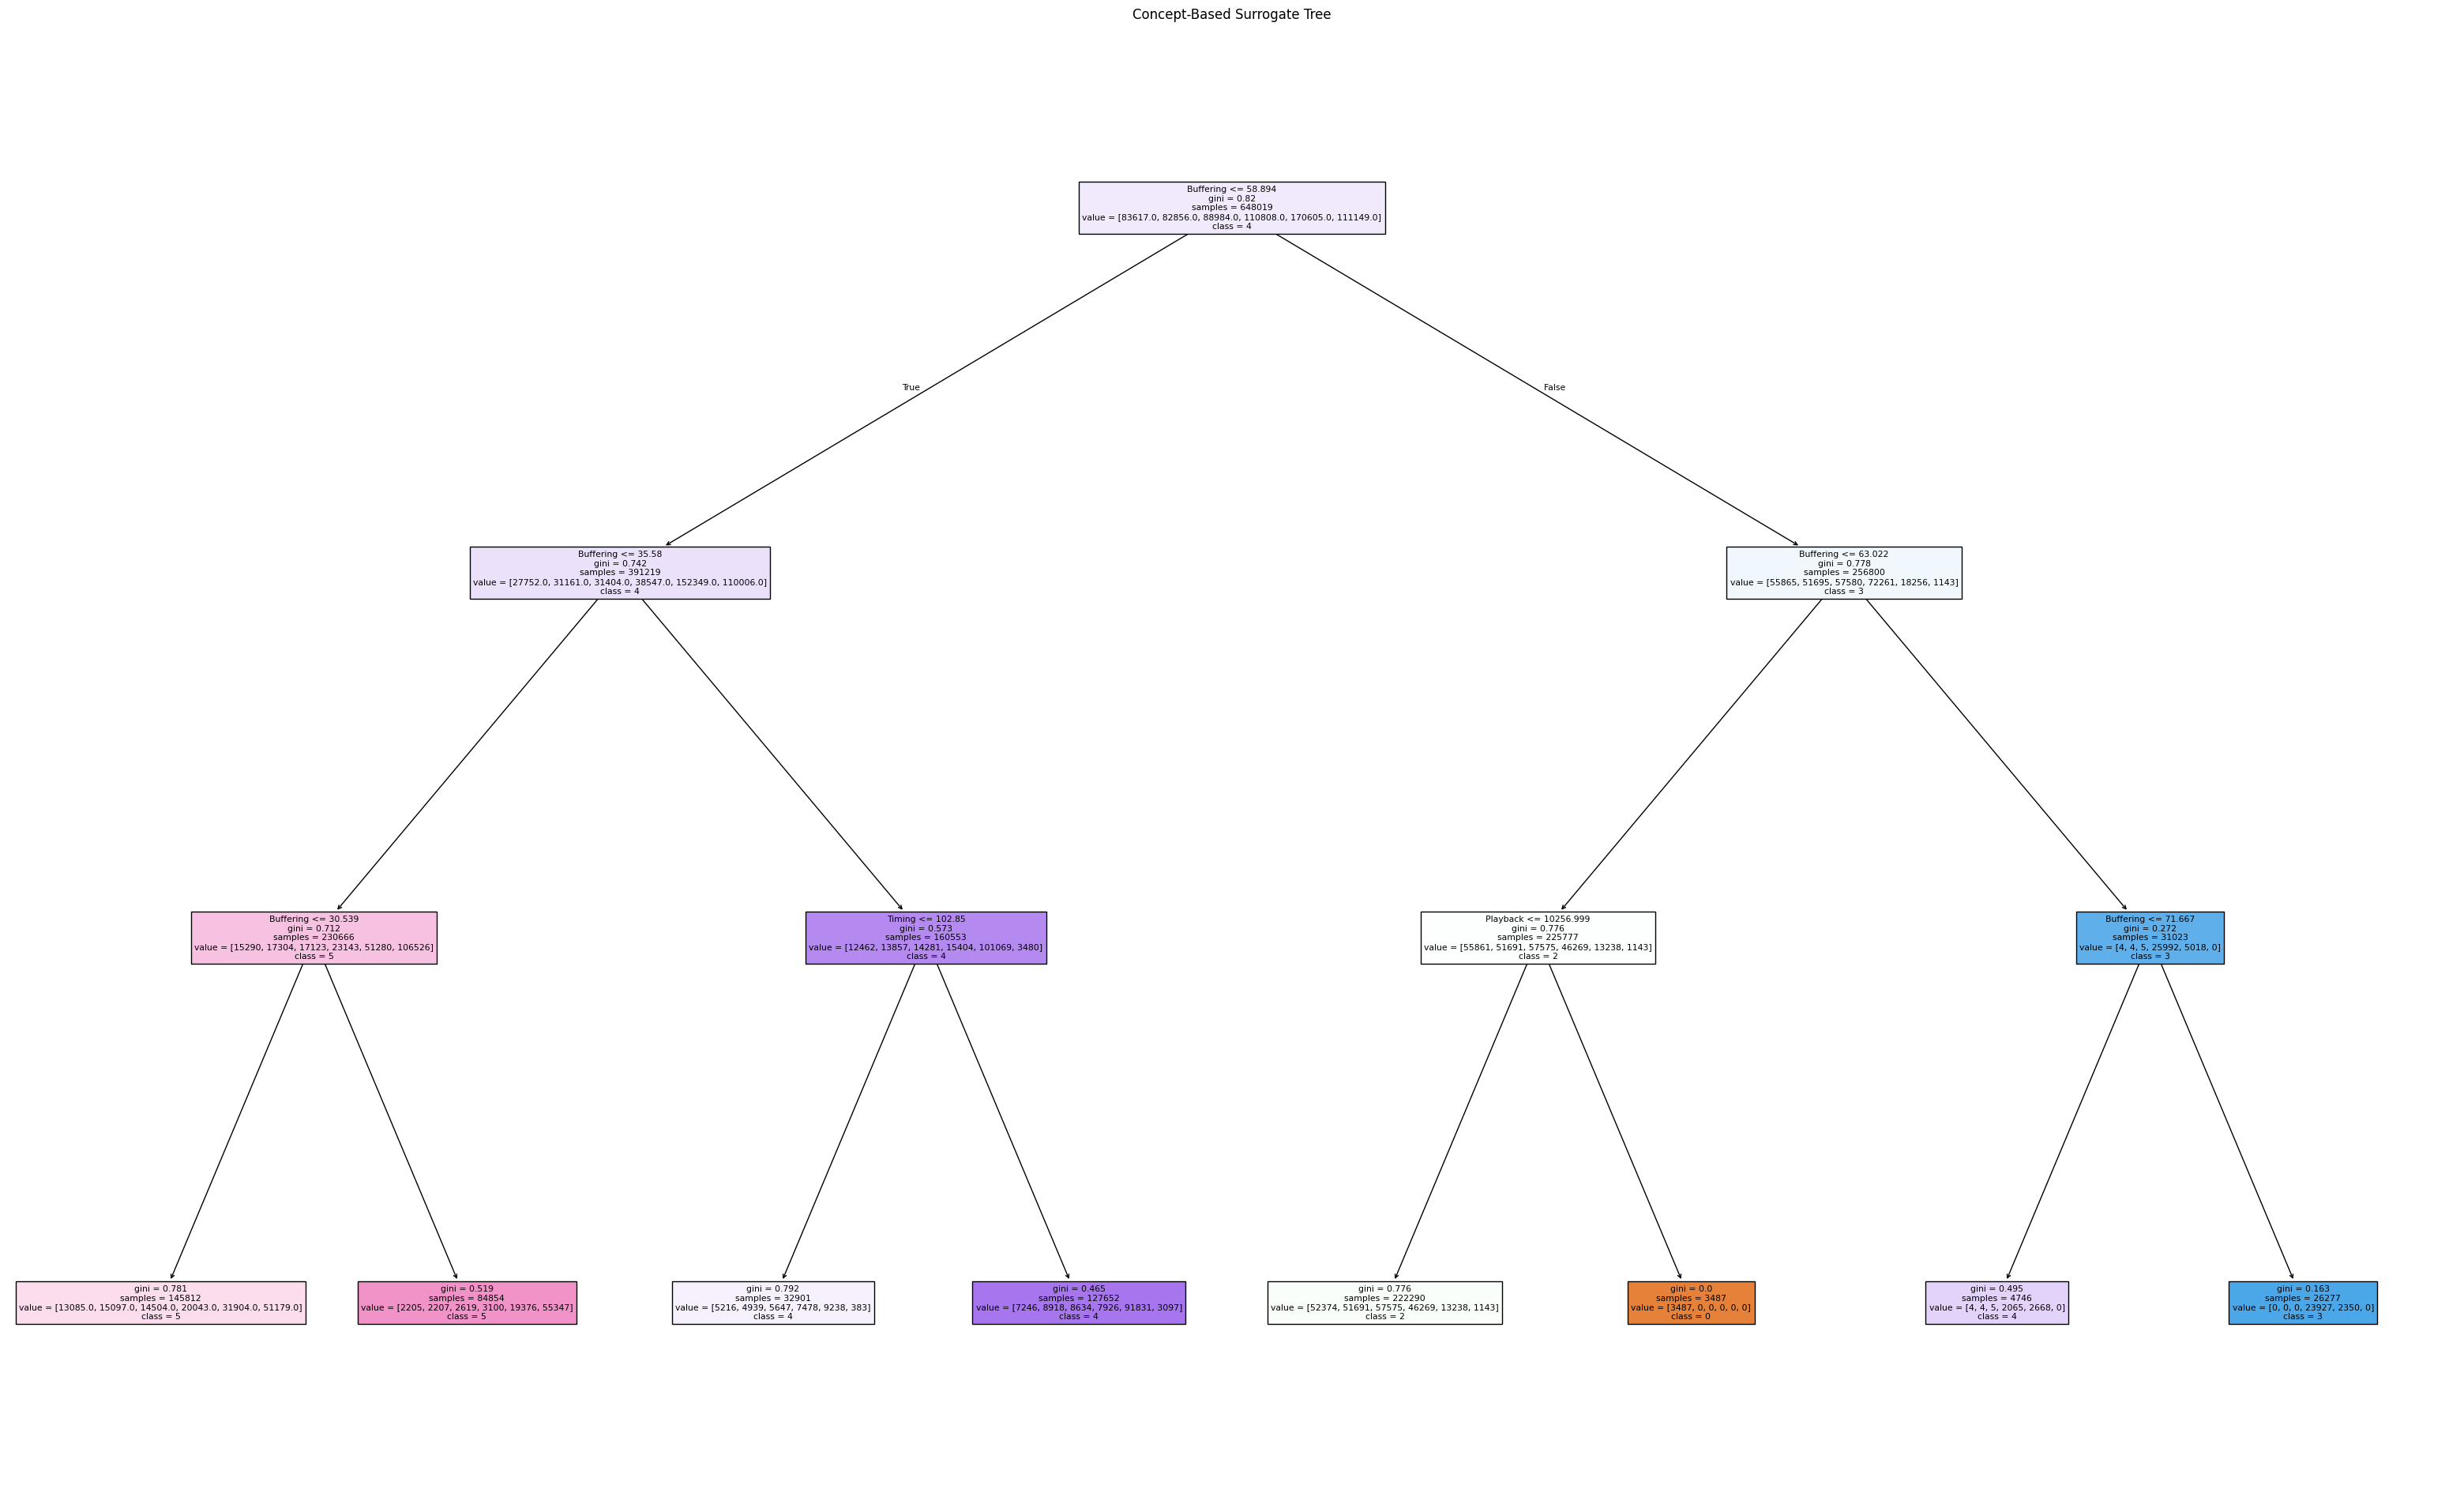

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a small decision tree on concept features
surrogate = DecisionTreeClassifier(max_depth=3, random_state=0)
surrogate.fit(X_test_concepts, y_test)

# Visualize the surrogate tree
plt.figure(figsize=(40, 24))
plot_tree(surrogate, 
          feature_names=X_test_concepts.columns, 
          filled=True, 
          class_names=[str(cls) for cls in sorted(y_test.unique())])
plt.title("Concept-Based Surrogate Tree")
plt.show()

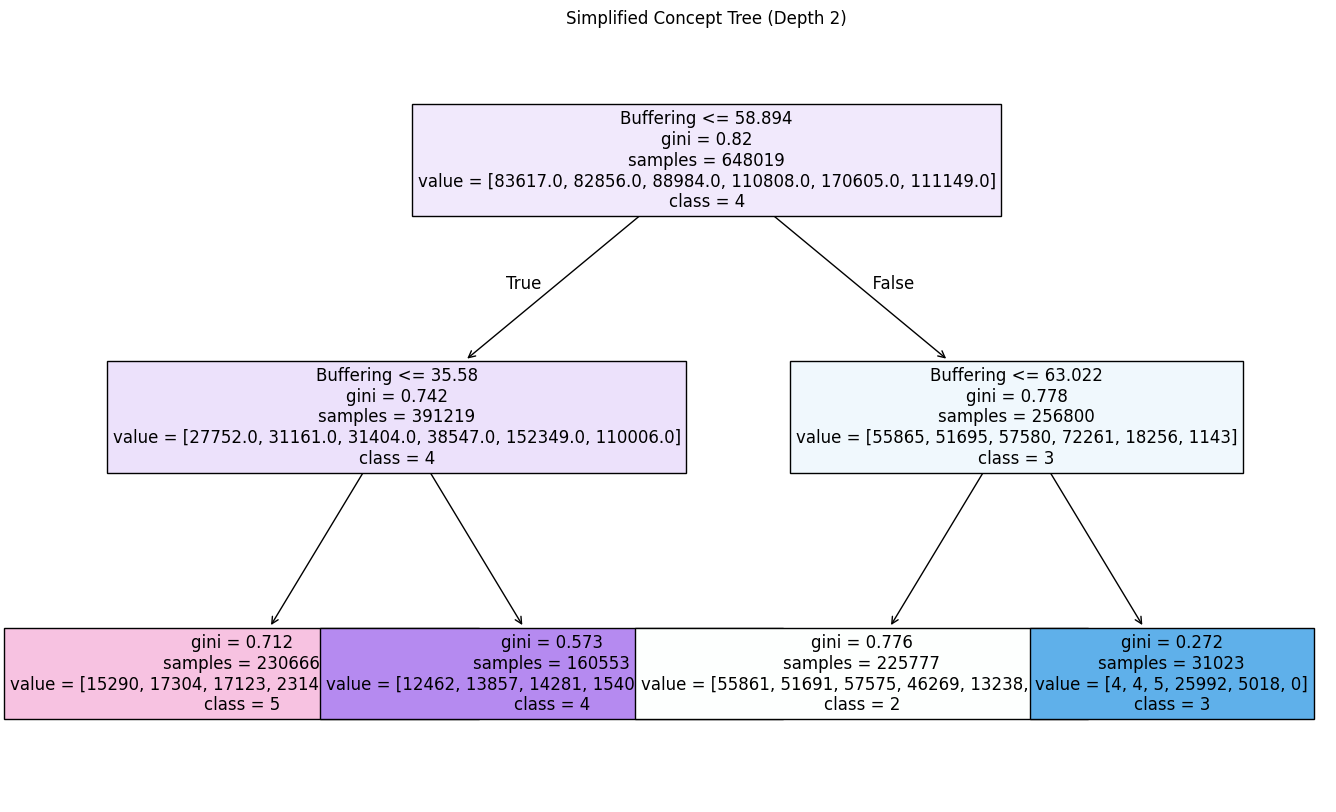

In [20]:
simpler_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
simpler_tree.fit(X_test_concepts, y_test)

plt.figure(figsize=(16, 10))
plot_tree(
    simpler_tree,
    feature_names=X_test_concepts.columns,
    filled=True,
    class_names=[str(cls) for cls in sorted(y_test.unique())],
    fontsize=12
)
plt.title("Simplified Concept Tree (Depth 2)")
plt.show()

In [21]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], X_test)